# 합성곱 신경망(Convolutional Neural Network, CNN)

- 완전연결: 인접하는 계층의 모든 뉴런과 결합됨
<br><br>
<완전 계층의 문제점>
    - 데이터의 형상이 무시됨.
    - 모든 입력 데이터를 동등한 뉴런(같은 차원의 뉴런)으로 취급하여 형상에 담긴 정보를 살릴 수 없음

### 용어 정리
<b><br><br>
- 특징맵: CNN에서 합성곱 계층의 입출력 데이터<br><br>
- 단일 곱셈-누산(fused multiplu-add FMA): 입력과 필터에서 대응하는 원소끼리 곱한 후 그 총합을 구함<br><br>
- 필터: 커널<br><br>
- 합성곱 연산: 필터의 윈도우를 일정 간격으로 이동해가며 입력데이터에 적용<br><br>
- 패딩: 입력 데이터 주변을 특정 값(예컨대 0)으로 채움, 출력 크기를 조정할 목적으로 사용<br><br>
- 스트라이드: 필터를 적용하는 위치의 간격<br><br>
- 풀링: 세로, 가로 방향의 공간을 줄이는 연산<br><br>
- im2col: 입력 데이터를 필터링(가중치 계산)하기 좋게 전개하는(펼치는) <br>
</b>


$$ OH = \frac{H+2P-FH}{S}+1\$$

$$ OW = \frac{W+2P-FW}{S}+1\$$
<br><br>필터의 채널 수는 입력 데이터의 채널 수와 같도록 설정해야 함

In [1]:
### 7.4.1 4차원 배열
import numpy as np
import pandas as pd

x = np.random.rand(10,1,28,28)
x.shape

(10, 1, 28, 28)

In [2]:
x[0].shape

(1, 28, 28)

In [4]:
x[1].shape

(1, 28, 28)

In [6]:
x[0,0].shape

(28, 28)

### im2col

In [9]:
#input_data: (데이터 수, 채널 수, 높이, 너비)의 4차원 배열로 이뤄진 입력 데이터
#filter_h: 필터의 높이
#filter_w: 필터의 너비
#strid: 스트라이드
#pad: 패딩
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [11]:
import sys, os
sys.path.append(os.pardir)
x1 = np.random.rand(1,3,7,7)#input data
col1 = im2col(x1,5,5,stride=1,pad=0)#2차원 행렬로 출력
print(col1.shape)#필터 크기와 동일(3x5x5)

(9, 75)


In [12]:
x2 = np.random.rand(10,3,7,7)#데이터 10개, input data
col2 = im2col(x2,5,5,stride=1,pad=0)
print(col2.shape)

(90, 75)


#### 합성곱 계층

In [14]:
class Convolution:
    def __init__(self,W,b,stride=1,pad=0):
        self.W = W#가중치
        self.b = b#편향
        self.stride = stride#스트라이드
        self.pad = pad#패딩
    
    def forward(self,x):
        FN,X,FH,FW = self.W.shape#필터개수,채널,필터높이,필터너비
        N,C,H,W = x.shape
        out_h = int(1+(H+2*self.pad-FH)/self.stride)#출력높이
        out_w = int(1+(W+2*self.pad-FW)/self.stride)#출력너비
        
        col = im2col(x,FW,FW,self.stride,self.pad)
        col_w = self.W.reshape(FN,-1).T#필터 전개; 2차원배열로 전개
        out = np.dot(col,col_W)+self.b#행렬 곱
        
        #축 순서 변경하기
        out = out.reshape(N,out_h,out_w,-1).transpose(0,3,1,2)#N,H,W,C -> N,C,H,W
        
        return out

#### 풀링 계층
1. 입력데이터를 전개한다
2. 행별 최대값을 구한다
3. 적절한 모양으로 성형한다

In [15]:
class Pooling:#풀링 계층
    def __init__(self,pool_h,pool_w,stride=1,pad=0):
        self.pool_h = pool_h#풀링 높이
        self.pool_w = pool_w#풀링 너비
        self.stride = stride#스트라이드
        self.pad = pad#패딩
        
    def forward(self,x):
        N,C,H,W = x.shape#데이터 개수,채널,높이,너비
        out_h = int(1+(H-self.pool_h)/self.stride)
        out_w = int(1+(W-self.pool_w)/self.stride)
        
        #1. 전개
        col = im2col(x,self.pool_h,self.pool_w,self.stride,self.pad)
        col = col.reshape(-1,self.pool_h*self.pool_w)#2차원 행렬
        
        #2. 최대값
        out = np.max(col,axis=1)
        
        #3. 성형
        out = out.reshape(N,out_h,out_w,C).transpose(0,3,1,2)
        
        return out

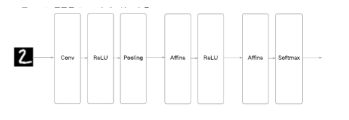

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import requests
url = "https://blog.kakaocdn.net/dn/WRuhc/btqQmO95Bbo/qCFeT9DKhHKQhKWkDcu9D1/img.png"

im = Image.open(requests.get(url, stream=True).raw)
plt.imshow(im)
plt.axis('off')
plt.show()

### 필요한 함수들

In [23]:
def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1


In [24]:
def relu(x):
    return np.maximum(0, x)

In [25]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [26]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

In [27]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx



In [28]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

$$ input $$
$$\downarrow$$
$$conv-relu-pooling$$
$$\downarrow$$
$$affine-relu$$
$$\downarrow$$
$$affine-softmax$$
$$\downarrow$$
$$output$$
<br>

In [30]:

class SImpleConvNet:
    
    def __init__(self,input_dim = (1,28,28),#입력데이터 차원
                conv_param = {'filter_num':30,'filter_size':5,
                             'pad':0, 'stride':1},#합성곱 계층의 하이퍼 파라미터(딕셔너리 형태)
                hidden_size = 100,
                output_size = 10,
                weight_init_std = 0.01):
        filter_num = conv_param['filter_num']#꺼냄
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size-filter_size+2*filter_pad)/filter_stride+1
        pool_output_size = int(filter_num*(conv_output_size/2)*(conv_output_size/2))#풀링 계층 출력 크기
    
        #가중치 매개변수 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0],filter_size,filter_size)#매개변수 초기화
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size,hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std*np.random.randn(hidden_size,output_size)
        self.params['b3'] = np.zeros(output_size)
        
        #CNN을 구성하는 계층들 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                          self.params['b1'],
                                          conv_param['stride'],
                                          conv_param['pad'])#합성곱계층
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)#풀링계층
        self.layers['Affine1'] = Affine(self.params['W2'],self.params['b2'])#완전연결1
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'],self.params['b3'])#완전연결2
        
        self.last_layer = SoftmaxwithLoss()
    
    def predict(self,x):#추론
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self,x,t):#손실함수의 값
        y = self.predict(x)
        return self.last_layer.forward(y,t)
    
    def gradient(self,x,t):#오차역전파법을 통한 기울기 구하기
        #순전파
        self.loss(x,t)
        
        #역전파
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()#거꾸로
        for layer in layers:
            dout = layer.backward(dout)
            
        #결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads